Please complete the `NotImplemented` parts of the code cells and write your answers in the markdown cells designated for your response to any questions asked. The tag `# AUTOGRADED` (all caps, with a space after `#`) should be at the beginning of each autograded code cell, so make sure that you do not change that. You are also not allowed to import any new package other than the ones already imported. Doing so will prevent the autograder from grading your code.

For the code submission, run the last cell in the notebook to create the submission zip file. If you are working in Colab, make sure to download and then upload a copy of the completed notebook itself to its working directory to be included in the zip file. Finally, submit the zip file to Gradescope.

After you finish the assignment and fill in your code and response where needed (all cells should have been run), save the notebook as a PDF using the `jupyter nbconvert --to pdf HW8.ipynb` command (via a notebook code cell or the command line directly) and submit the PDF to Gradescope under the PDF submission item. If you cannot get this to work locally, you can upload the notebook to Google Colab and create the PDF there. You can find the notebook containing the instruction for this on Canvas.

If you are running the notebook locally, make sure you have created a virtual environment (using `conda` for example) and have the proper packages installed. We are working with `python=3.10` and `torch>=2`.

Files to be included in submission:

- `HW8.ipynb`
- `generator_config.yaml`
- `discriminator_config.yaml`
- `train_config.yaml`

In [2]:
"""
DO NOT MODIFY THIS CELL OR ADD ANY ADDITIONAL IMPORTS ANYWHERE ELSE IN THIS NOTEBOOK!
"""
from typing import Sequence, Union
from tqdm import tqdm
import numpy as np

import matplotlib.pyplot as plt
# plt.rcParams.update({'figure.autolayout': True})
from IPython.display import display, clear_output

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from HW8_utils import AirfoilDataset

if torch.cuda.is_available():
    Device = 'cuda'
elif torch.backends.mps.is_available():
    Device = 'mps'
else:
    Device = 'cpu'
print(f'Device is {Device}')

Device is cpu


# Fundamentals of Generative Adversarial Networks (30)

First, you have to answer some questions to validate your knowledge about the fundamentals of GANs. Explain your reasoning for each question, and keep your response concise.

You can also verify your answers by what you observe in the programming section of the assignment.

## __QUESTION 1__ (10)

For a GAN with a well-balanced generator and discriminator, what should the output of the discriminator be for real data $D(x)$ and fake data $D\big(G(z)\big)$ in the early iterations of training? How should $D(x)$ and $D\big(G(z)\big)$ change as the training progresses? (For each case, should it be closer to 0 or 0.5 or 1?)

What would indicate getting close to a successfully trained GAN?

__RESPONSE__:

**Early iterations of training:**

- The discriminator output for real data $D(x)$ should be close to **1**, since it can easily recognize real samples.
- The discriminator output for fake data $D(G(z))$ should be close to **0**, as the generator initially produces poor-quality outputs that are easy to detect as fake.

**As training progresses:**

- The discriminator output for real data $D(x)$ should be closer to **0.5**, as it becomes less certain in recognizing real and fake data.
- The discriminator output for fake data $D\big(G(z)\big)$ should also be closer to **0.5**, as the generator improves and starts producing more realistic data.

**A successfully trained GAN is indicated when:**

- Both $D(x)$ and $D\big(G(z)\big)$ get close to **0.5**, indicating that the discriminator cannot distinguish between real and fake data. This means the generator is producing realistic outputs.

## __QUESTION 2__ (10)

Assume you have started training a GAN, and you observe in the early iterations that the generator and discriminator losses are similar. The output of the discriminator for real and fake data are also similar. 

Do you think that the training will be successful and lead to a good GAN capable of generating realistic samples? If not, what is the problem and how could you mitigate it?

__RESPONSE__:

Under the stated observation, the training will most likely be unsuccessful and lead to a GAN that is unable to generate realistic samples. The model is failing to learn meaningful distinctions between real and fake data, which can lead to **mode collapse**.

**Problem:** 
- The discriminator is unable to learn meaningful distinctions between real and fake samples, which can lead to a mode collapse.

**Mitigation:**
- Apply techniques such as **label smoothing**, **gradient penalty**, or **feature matching** to stabilize training.  
- Improve weight initialization for both the generator and discriminator.  
- Use different learning rates for the generator and discriminator to balance learning speeds.  
- Consider switching to more stable loss functions, such as the **Wasserstein loss (WGAN)**.
 

## __QUESTION 3__ (10)

Assume you have started training a GAN, and you observe that the discriminator loss quickly converges to zero, while the generator loss seems unstable or very large even after training for some time. What do you think the discriminator score is for real and fake data?

Do you think that the training will be successful and lead to a good GAN capable of generating realistic samples? If not, what is the problem and how could you mitigate it?

__RESPONSE__:

Under the stated observation, the discriminator score for real data \( D(x) \) is likely **close to 1** and the discriminator score for fake data \( D(G(z)) \) is likely **close to 0**.

The training will not be successful, since the discriminator overpowers the generator, preventing it from learning effectively and resulting in meaningless outputs.

**Problem:**
- The **discriminator overpowers the generator**, leading to **vanishing gradients** for the generator. As a result, the generator receives very weak learning signals and fails to improve.

**Mitigation:**
- Use a **lower learning rate** for the discriminator to slow down its learning.
- Apply **label smoothing** to reduce the discriminator’s confidence.
- Consider switching to more stable loss functions, such as the **Wasserstein loss (WGAN)**.

# Implement and train a GAN to generate airfoils (70)

You are provided with the UIUC airfoil dataset consisting of 1547 airfoil profiles. The Dataset class to load the data is provided in `HW8_utils.py`. Let's take a look at the dataset. Each sample consists of the y-coordinates of points at pre-defined locations on the x-axis, as well as the name of the airfoil. You will not need the names.

In [3]:
airfoil_dataset = AirfoilDataset()
print(f'dataset has {len(airfoil_dataset)} samples')

dataset has 1547 samples


In [4]:
sample_idx = 431
y, name = airfoil_dataset[sample_idx]
print(f'y is {type(y)} and has shape {y.shape} and dtype {y.dtype}')

y is <class 'numpy.ndarray'> and has shape (200,) and dtype float32


## Implement a Generator and a Discriminator (20)

You do not need a complicated architecture for the generator and discriminator in this assignment. You can use the example from the recitation to implement the general architecture, but do not copy the exact models, since there might be details specific to the datasets. Try to implement the models by yourself to get comfortable with defining soft-coded atchutectures.

In [5]:
# AUTOGRADED

class Generator(nn.Module):

    def __init__(
            self,
            latent_size: int,
            output_size: int,
            hidden_dims: Sequence[int] = [64, 128, 256],
            ):
        super().__init__()
        
        layers = []
        input_size = latent_size

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(input_size, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            input_size = hidden_dim

        layers.append(nn.Linear(input_size, output_size))
        # layers.append(nn.Tanh())
        layers.append(nn.AvgPool1d(kernel_size=3, stride=1, padding=1))

        self.model = nn.Sequential(*layers)
            
    def forward(
            self, 
            z: torch.FloatTensor, # (batch_size, latent_size)
            ) -> torch.FloatTensor: # (batch_size, *output_shape)
        """
        Input z is the latent vector, typically sampled from N(0, I)
        Outputs generated samples
        """
        return self.model(z)

    def generate(
            self,
            n_samples: int,
            device: str = Device,
            ) -> torch.FloatTensor: # (n_samples, output_size)
        """
        move self to the device
        sample n_samples latent vectors from N(0, I)
        generate n_samples samples
        """
        self.to(device)
        z = torch.randn(n_samples, self.model[0].in_features, device=device).clamp(-2, 2)
        return self.forward(z)


class Discriminator(nn.Module):

    def __init__(
            self,
            input_size: int,
            hidden_dims: Sequence[int] = [256, 128, 64],
            
            ):
        super().__init__()

        layers = []
        in_dim = input_size

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.LeakyReLU(0.2))
            layers.append(nn.Dropout(0.3))
            in_dim = hidden_dim

        layers.append(nn.Linear(in_dim, 1))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(
            self,
            x: torch.FloatTensor, # (batch_size, input_size)
            ) -> torch.FloatTensor: # (batch_size, 1)
        
        return self.model(x)

## Tracking and Visualization

In [6]:
class GAN_Tracker:
    """
    Logs and plots different loss terms of a GAN during training.
    """
    def __init__(
            self, 
            n_iters: int,
            plot_freq: Union[int, None] = None, # plot every plot_freq iterations
            ):
        
        self.real_scores = []
        self.fake_scores = []
        self.D_losses = []
        self.G_losses = []

        self.plot = plot_freq is not None
        self.iter = 0
        self.n_iters = n_iters
		
        if self.plot:
            self.plot_freq = plot_freq
            self.plot_results()


    def plot_results(self):
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(13, 3), sharex=True)

        # Score plot:
        self.real_score_curve, = self.ax1.plot(
            range(1, self.iter+1),
            self.real_scores,
			label = r'$D(x)$',
            )
        self.fake_score_curve, = self.ax1.plot(
            range(1, self.iter+1),
            self.fake_scores,
            label = r'$D(G(z))$',
            )

        self.ax1.set_xlim(0, self.n_iters+1)
        self.ax1.set_ylim(0, 1)
        self.ax1.set_xlabel('Iteration')
        self.ax1.set_ylabel('Discriminator Score')
        self.ax1.set_title('Discriminator Score')
        self.ax1.grid(linestyle='--')
        self.ax1.legend()

        # Loss plot:
        self.D_loss_curve, = self.ax2.plot(
            range(1, self.iter+1),
            self.D_losses,
			label = 'D',
            )
        self.G_loss_curve, = self.ax2.plot(
            range(1, self.iter+1),
            self.G_losses,
            label = 'G',
            )
        self.ax2.set_xlim(0, self.n_iters+1)
        self.ax2.set_xlabel('Iteration')
        self.ax2.set_ylabel('Loss')
        self.ax2.set_title('Learning Curve')
        self.ax2.grid(linestyle='--')
        self.ax2.legend()

        self.samples_fig, self.samples_axes = plt.subplots(4, 6, figsize=(12, 8), sharex=True, sharey=True)
        self.sample_axes = self.samples_axes.flat
        self.samples = []
        for ax in self.sample_axes:
            self.samples.append(ax.plot(airfoil_dataset.get_x(), np.zeros_like(airfoil_dataset.get_x()))[0])
            ax.set_xlim(-0.1, 1.1)
            ax.set_ylim(-0.6, 0.6)
            ax.set_aspect('equal')
            ax.grid(linestyle='--')


    def update(
            self, 
            real_score: float,
            fake_score: float,
            D_loss: float,
            G_loss: float,
            ):
        self.real_scores.append(real_score)
        self.fake_scores.append(fake_score)
        self.D_losses.append(D_loss)
        self.G_losses.append(G_loss)
        self.iter += 1
		
        if self.plot and self.iter % self.plot_freq == 0:

            # score plot:
            self.real_score_curve.set_data(range(1, self.iter+1), self.real_scores)
            self.fake_score_curve.set_data(range(1, self.iter+1), self.fake_scores)
            self.ax1.relim()
            self.ax1.autoscale_view()

            # loss plot:
            self.D_loss_curve.set_data(range(1, self.iter+1), self.D_losses)
            self.G_loss_curve.set_data(range(1, self.iter+1), self.G_losses)
            self.ax2.relim()
            self.ax2.autoscale_view()

            self.samples_fig.suptitle(f'Generated Samples at Iteration {self.iter}')

            self.fig.canvas.draw()
            clear_output(wait=True)
            display(self.fig)
            display(self.samples_fig)

    
    def get_samples(
            self, 
            samples: torch.FloatTensor, # (n_samples, *output_shape)
            ):
        for sample, sample_img in zip(samples, self.samples):
            sample_img.set_ydata(sample.detach().cpu().numpy())
            

## Losses (15)

Hint: use `F.binary_cross_entropy` with the right input and target.

In [7]:
def bce_loss(pred, target_val):
    target = torch.full_like(pred, target_val)
    return F.binary_cross_entropy(pred, target)


def D_real_loss_fn(
        D_real: torch.FloatTensor, # (batch_size, 1)
        ) -> torch.FloatTensor: # ()
    """
    D_real is D(x), the discriminator's output when fed with real images
    We want this to be close to 1, because the discriminator should recognize real images
    """
    return bce_loss(D_real, 0.9)


def D_fake_loss_fn(
        D_fake: torch.FloatTensor, # (batch_size, 1)
        ) -> torch.FloatTensor: # ()
    """
    D_fake is D(G(z)), the discriminator's output when fed with generated images
    We want this to be close to 0, because the discriminator should not be fooled
    """
    return bce_loss(D_fake, 0.1)


def G_loss_fn(
        D_fake: torch.FloatTensor, # (batch_size, 1)
        ) -> torch.FloatTensor: # ()
    """
    D_fake is D(G(z)), the discriminator's output when fed with generated images
    We want this to be close to 1, because the generator wants to fool the discriminator
    """
    return bce_loss(D_fake, 0.9)

## Training (15)

We suggest you avoid copy-pasting from the recitation and try to remember the steps in training a GAN to learn it well. After you implement your solution, compare with the recitation and correct your code accordingly.

In [8]:
def train_GAN(
        generator: Generator,
        discriminator: Discriminator,
        train_dataset: Dataset,
        device: str = Device,
        plot_freq: int = 100,
        
        # Generator 
        optimizer_name_G: str = 'Adam',
        optimizer_config_G: dict = dict(lr=1e-3),
        lr_scheduler_name_G: Union[str, None] = None,
        lr_scheduler_config_G: dict = dict(),

        # Discriminator
        optimizer_name_D: str = 'Adam',
        optimizer_config_D: dict = dict(lr=1e-3),
        lr_scheduler_name_D: Union[str, None] = None,
        lr_scheduler_config_D: dict = dict(),

        n_iters: int = 10000,
        batch_size: int = 64,
        ):
    
    generator = generator.to(device)
    discriminator = discriminator.to(device)

    optimizer_G: optim.Optimizer = optim.__getattribute__(optimizer_name_G)(generator.parameters(), **optimizer_config_G)
    if lr_scheduler_name_G is not None:
        lr_scheduler_G: lr_scheduler._LRScheduler = lr_scheduler.__getattribute__(lr_scheduler_name_G)(optimizer_G, **lr_scheduler_config_G)

    optimizer_D: optim.Optimizer = optim.__getattribute__(optimizer_name_D)(discriminator.parameters(), **optimizer_config_D)
    if lr_scheduler_name_D is not None:
        lr_scheduler_D: lr_scheduler._LRScheduler = lr_scheduler.__getattribute__(lr_scheduler_name_D)(optimizer_D, **lr_scheduler_config_D)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

    tracker = GAN_Tracker(n_iters=n_iters, plot_freq=plot_freq)

    iter_pbar = tqdm(range(n_iters), desc='Training', unit='iter')
    iter = 0

    while iter < n_iters:

        for x_real, _ in train_loader:

            x_real = x_real.to(device)
            n_samples = len(x_real)
            
            # ============ Train Discriminator ============
            
            discriminator.train()
            generator.eval()

            with torch.no_grad():
                z = torch.randn(n_samples, generator.model[0].in_features, device=device).clamp(-2, 2)
                x_fake = generator(z)

            D_real = discriminator(x_real)
            D_fake = discriminator(x_fake)

            D_real_loss = D_real_loss_fn(D_real)
            D_fake_loss = D_fake_loss_fn(D_fake)
            D_loss = D_real_loss + D_fake_loss

            optimizer_D.zero_grad()
            D_loss.backward()
            optimizer_D.step()

            if lr_scheduler_name_D is not None:
                lr_scheduler_D.step()

            D_real_avg = D_real.mean().item()
            D_fake_avg = D_fake.mean().item()
            D_loss_item = D_loss.item()

            # ============ Train Generator ============
            
            generator.train()
            discriminator.eval()
            
            z = torch.randn(n_samples, generator.model[0].in_features, device=device)
            x_fake = generator(z)
            D_fake = discriminator(x_fake)

            G_loss = G_loss_fn(D_fake)

            optimizer_G.zero_grad()
            G_loss.backward()
            optimizer_G.step()

            if lr_scheduler_name_G is not None:
                lr_scheduler_G.step()

            G_loss_item = G_loss.item()

            # ============ Logging =================
            iter += 1
            iter_pbar.update(1)
            if iter % plot_freq == 0:
                with torch.inference_mode():
                    tracker.get_samples(generator.generate(n_samples=24, device=device))
            tracker.update(D_real_avg, D_fake_avg, D_loss_item, G_loss_item)

            if iter >= n_iters:
                break

## Find and train a good model (20)

As usual, find a good set of hyperparameters and train your model. However, you have to evaluate your model qualitatively by looking at some generated samples. A nice airfoil would be an airfoil with a smooth surface. For this dataset, making a GAN work is more tricky than what you experienced with a VAE, so the generated samples may not be as smooth. In the figure below, all samples are considered nice enough except one.

Your grade also depends on the diversity of the generated samples. If all your samples look the same, your GAN is suffering from _mode collapse_, and you will get at most 5 points depending on the quality of the sample. If your samples are diverse but not nice, you will get 0 (garbage), 5 (too bad, but looks like airfoils), 10 (not bad), or 15 (almost there) points depending on how nice they are. The grading will be generously done.


__HINT__: Think about how to balance the generator and discriminator and stabilize the training as it progresses. You may find using learning rate schedulers useful.

__DO NOT CHANGE__ `input_size` and `latent_size`.

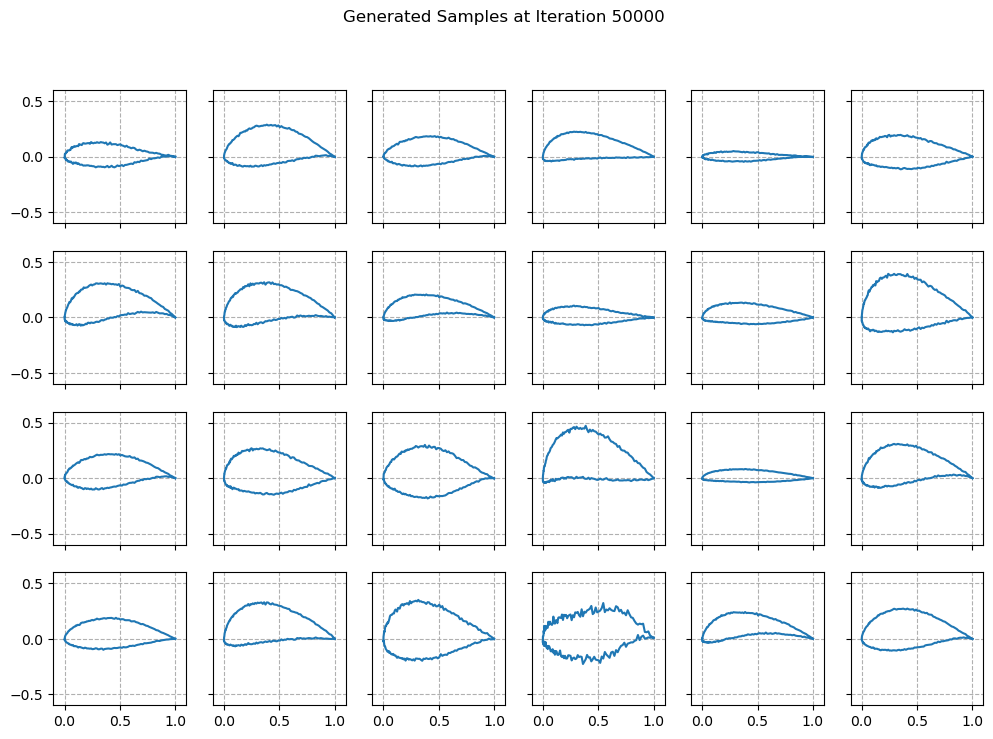

In [12]:
"""
Choose model and training configuration
"""
input_size = 200 # DO NOT CHANGE
latent_size = 16 # DO NOT CHANGE

generator_config = dict(
    latent_size = latent_size,
    output_size = input_size,
    # hidden_dims = [256, 512],
    hidden_dims = [512, 256],
    )

discriminator_config = dict(
    input_size = input_size,
    hidden_dims = [512, 256, 128],
    )

train_config = dict(
    # Generator
    optimizer_name_G = 'AdamW',
    optimizer_config_G = dict(lr=5e-4, betas=(0.5, 0.999)),
    lr_scheduler_name_G = 'CosineAnnealingWarmRestarts',
    lr_scheduler_config_G = dict(T_0=70000, T_mult=1, eta_min=1e-5),
   
    # Discriminator
    optimizer_name_D = 'AdamW',
    optimizer_config_D = dict(lr=1e-3, betas=(0.5, 0.999)),
    lr_scheduler_name_D = 'CyclicLR',
    lr_scheduler_config_D = dict(base_lr=5e-4, max_lr=5e-5, step_size_up=500, step_size_down=500, mode='triangular2'),

    n_iters = 70000,
    batch_size = 128,
    )

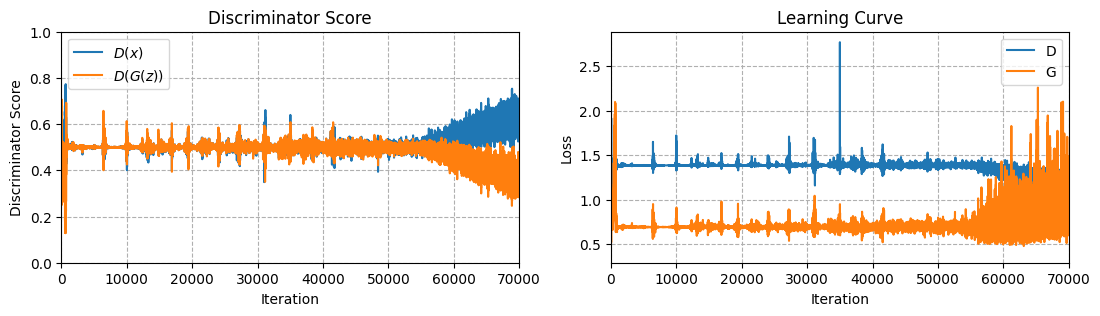

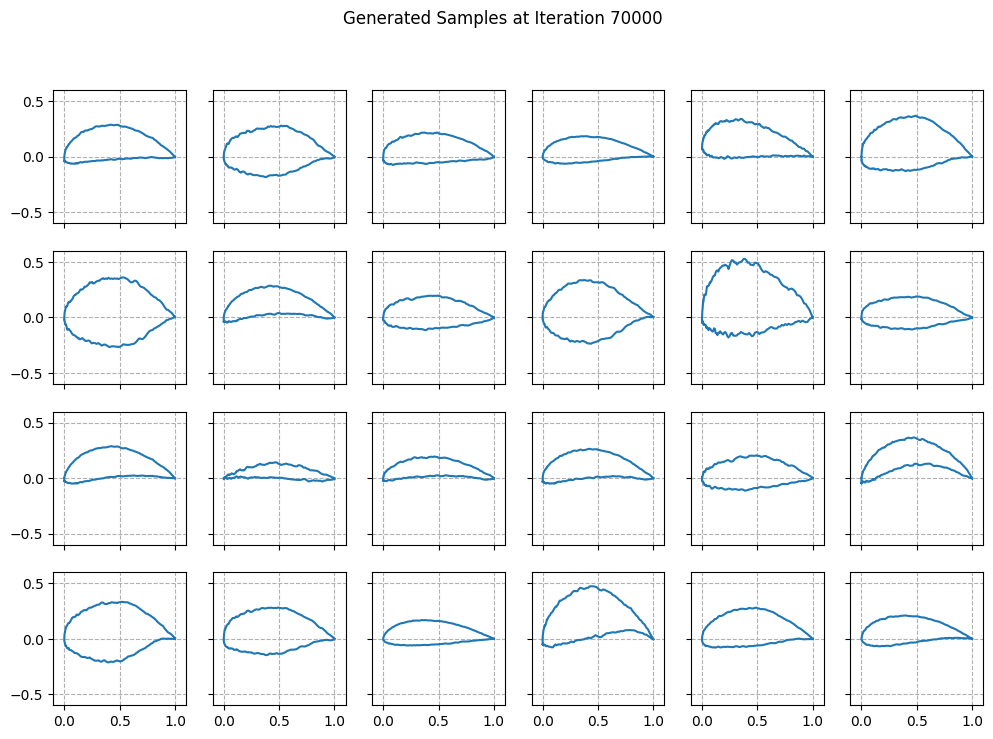

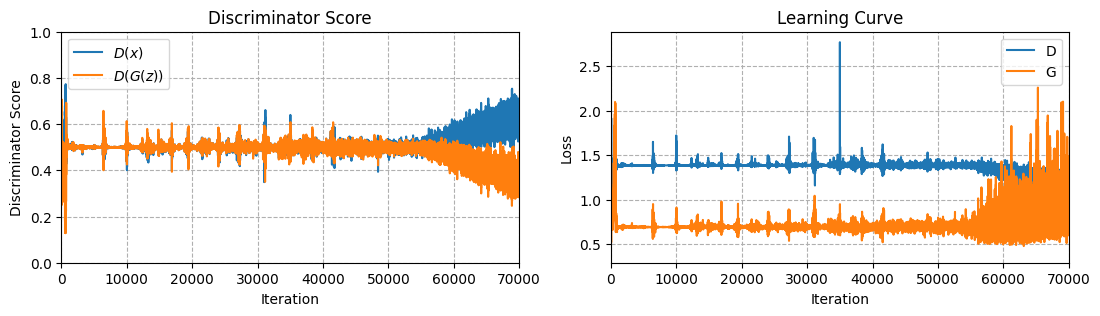

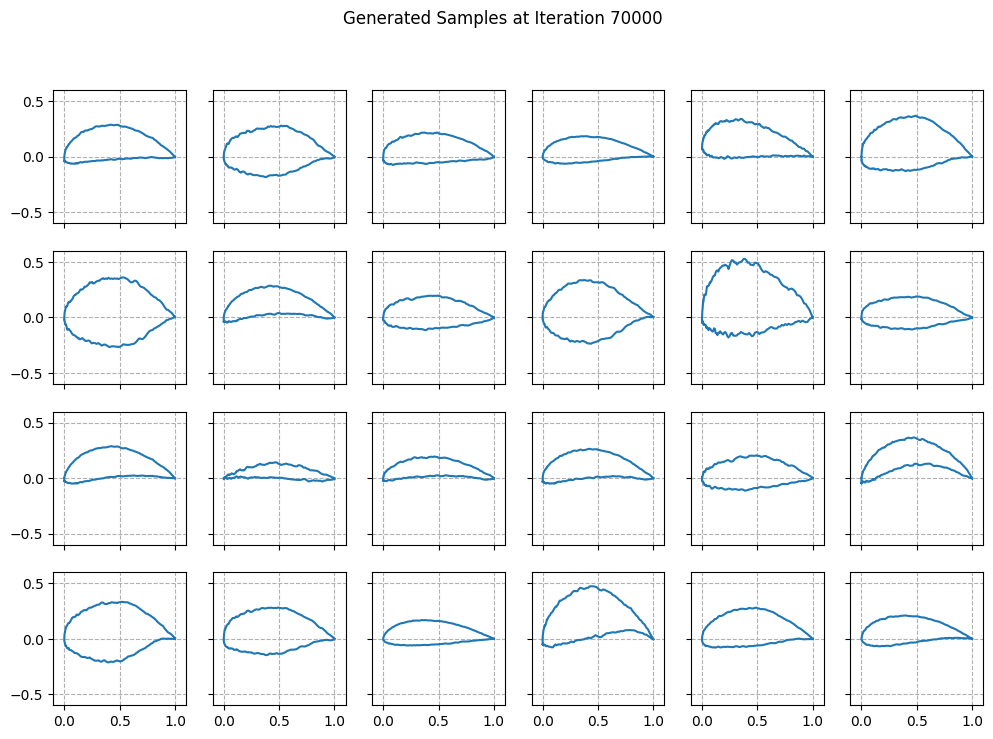

Training: 100%|██████████| 70000/70000 [21:42<00:00, 55.10iter/s]

In [13]:
if __name__ == '__main__':
    generator = Generator(**generator_config)
    discriminator = Discriminator(**discriminator_config)
    train_GAN(
        generator = generator, 
        discriminator = discriminator, 
        train_dataset = airfoil_dataset,
        device = Device,
        plot_freq = 500,
        **train_config,
        )

# Zip files for submission

In [ ]:
from HW8_utils import save_yaml, zip_files

save_yaml(generator_config, 'generator_config.yaml')
save_yaml(discriminator_config, 'discriminator_config.yaml')
save_yaml(train_config, 'train_config.yaml')

submission_files = ['HW8.ipynb', 'generator_config.yaml', 'discriminator_config.yaml', 'train_config.yaml']
zip_files('HW8_submission.zip', submission_files)

Training: 100%|██████████| 70000/70000 [21:30<00:00, 66.56iter/s]